In [7]:
import pymysql
import configparser
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from itertools import combinations

from tqdm.notebook import tqdm
import pymysql
import configparser
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [15]:
import importlib
import src.utils
importlib.reload(src.utils)
from src.utils import get_dataframe_from_pymysql_cursor, generate_comparitive_violin_plot

In [8]:
config = configparser.ConfigParser()
filename = './resource/db.ini'
config.read(filename)

['./resource/db.ini']

In [9]:
connection = pymysql.connect(host=config['DATABASE']['HOST'],
                             user=config['DATABASE']['USERNAME'],
                             password=config['DATABASE']['PASSWORD'],
                             db="patent_20200630",
                             charset='utf8mb4',
                             defer_connect=True)

In [10]:
old_data_distances = []
new_data_distances = []

In [11]:
old_data_id_query_template = """
SELECT id from inventor order by id limit {l} offset {o}
"""

old_data_query_template = """
SELECT r.inventor_id , CONCAT_WS(' ',r.name_first, r.name_last) inventor_name from rawinventor r join ({id_query}) id on id.id = r.inventor_id order by r.inventor_id
"""

In [12]:
limit = 50000
offset = 0

In [12]:
pbar = tqdm(total=3977356)
mode='w'
while True:
    id_query = old_data_id_query_template.format(l=limit, o=offset)
    data_query = old_data_query_template.format(id_query=id_query)
    current_df = get_dataframe_from_pymysql_cursor(connection, data_query)
    if current_df.shape[0] < 1:
        break
    current_sizes =current_df.groupby("inventor_id").apply(calculate_cluster_distances).reset_index()
    old_data_distances.append(current_sizes)
#     current_sizes.to_csv("./data/old_within_cluster_distance.csv", index=False)
#     mode='a'
    pbar.update(limit)
    offset += limit
pbar.close()



In [ ]:
old_data_distances_x = pd.concat(old_data_distances)



In [14]:
old_na_dropped_distances = old_data_distances_x[~old_data_distances_x.levenshtein.isnull()]

In [15]:
old_na_dropped_distances.to_csv("./data/old_cluster_distances.csv", index=False)

In [16]:
new_data_id_query_template = """
SELECT disambiguated_id 
from tmp_inventor_disambiguation_granted_ids order by disambiguated_id limit {l} offset {o}
"""

new_data_query_template = """
SELECT tidg.disambiguated_id , CONCAT_WS(' ',r.name_first, r.name_last) inventor_name from tmp_inventor_disambiguation_granted tidg
         join ({id_query}) tidg2
              on tidg2.disambiguated_id = tidg.disambiguated_id
         join rawinventor r on tidg.uuid = r.uuid order by tidg.disambiguated_id
"""

In [19]:
limit = 75000
offset = 0

In [21]:
pbar = tqdm(total=3977356)
while True:
    id_query = new_data_id_query_template.format(l=limit, o=offset)
    data_query = new_data_query_template.format(id_query=id_query)
    current_df = get_dataframe_from_pymysql_cursor(connection, data_query)
    if current_df.shape[0] < 1:
        break
    new_data_distances.append(
        current_df.groupby("disambiguated_id").apply(
            calculate_cluster_distances).reset_index())
    pbar.update(limit)
    offset += limit

pbar.close()


In [22]:

new_data_distances_x = pd.concat(new_data_distances)

new_na_dropped_distances = new_data_distances_x[~new_data_distances_x.levenshtein.isnull()]

In [23]:
new_na_dropped_distances.to_csv("./data/new_cluster_distances.csv", index=False)

In [13]:
old_na_dropped_distances = pd.read_csv("./data/old_cluster_distances.csv")
new_na_dropped_distances = pd.read_csv("./data/new_cluster_distances.csv")

In [16]:
fig, plots = generate_comparitive_violin_plot(
    old_na_dropped_distances[
        old_na_dropped_distances.levenshtein > 0].levenshtein,
    new_na_dropped_distances[
        new_na_dropped_distances.levenshtein > 0].levenshtein,
    log=True)

In [17]:
plots[0].set_ylabel("Log of Levenshtein Distance")
plots[0].set_title("Within Cluster Distances (Old Disambiguation)")
plots[0].set_xticks([])
plots[1].set_ylabel("Log of Levenshtein Distance")
plots[1].set_title("Within Cluster Distances (New Disambiguation)")
plots[0].set_xticks([])

[]

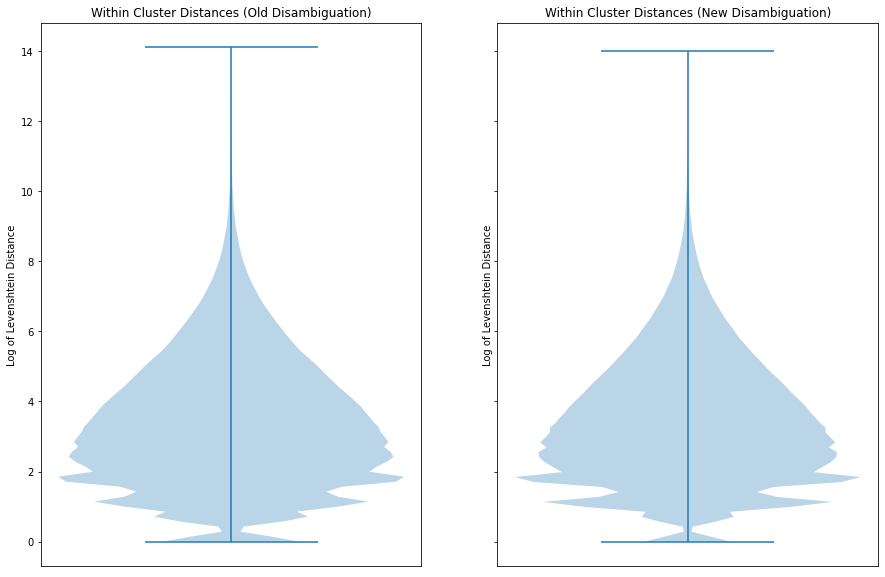

In [18]:
fig